In [2]:
library(ggplot2)
library(forecast)
library(dplyr)
library(colortools)

monthly_milk <- read.csv("C:\\Users\\HP\\Downloads\\monthly_milk.csv")  # Milk production per cow per month


head(monthly_milk)

month,milk_prod_per_cow_kg
1962-01-01,265.05
1962-02-01,252.45
1962-03-01,288.00
1962-04-01,295.20
1962-05-01,327.15
1962-06-01,313.65


In [3]:
# YYYY - DD - MM

# Milk Production

In [4]:
class(monthly_milk$month)

[1] "factor"

In [5]:
# Coerce to `Date` class
monthly_milk$month_date <- as.Date(monthly_milk$month, format = "%Y-%m-%d")

In [6]:
class(monthly_milk$month_date)

[1] "Date"

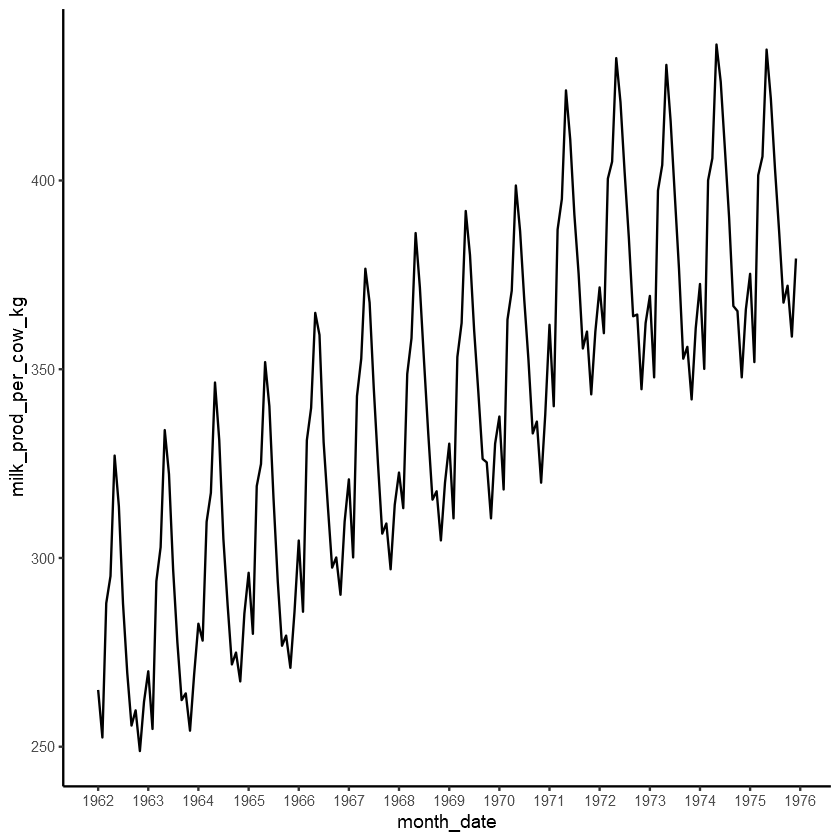

In [7]:
ggplot(monthly_milk, aes(x = month_date, y = milk_prod_per_cow_kg)) +
  geom_line() +
  scale_x_date(date_labels = "%Y", date_breaks = "1 year") +
  theme_classic()

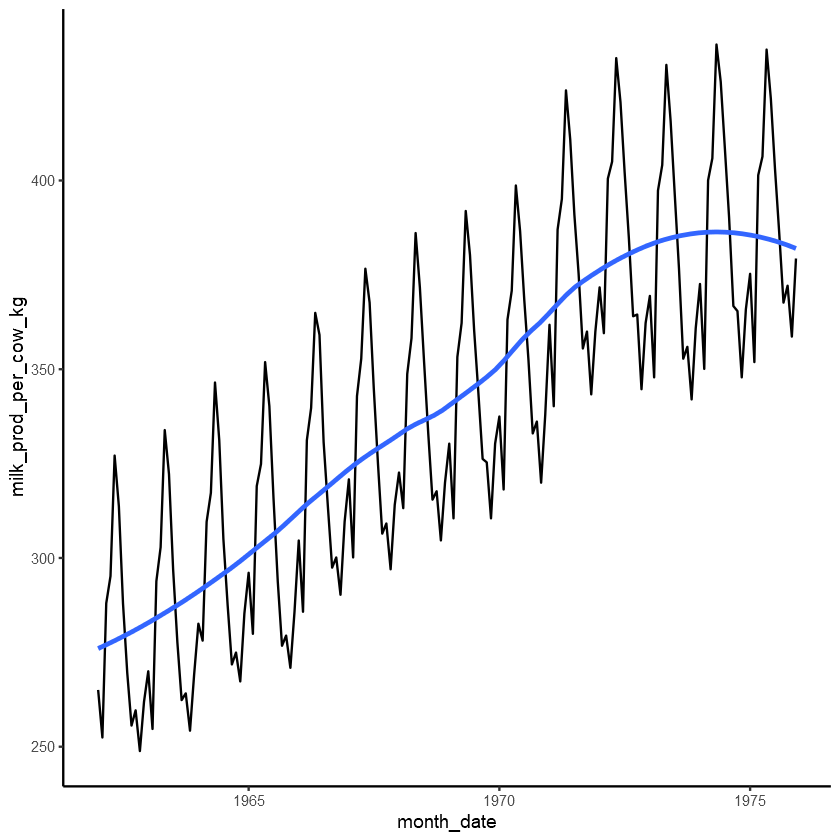

In [8]:
ggplot(monthly_milk, aes(x = month_date, y = milk_prod_per_cow_kg)) +
  geom_line() +
  geom_smooth(method = "loess", se = FALSE, span = 0.6) +
  theme_classic()

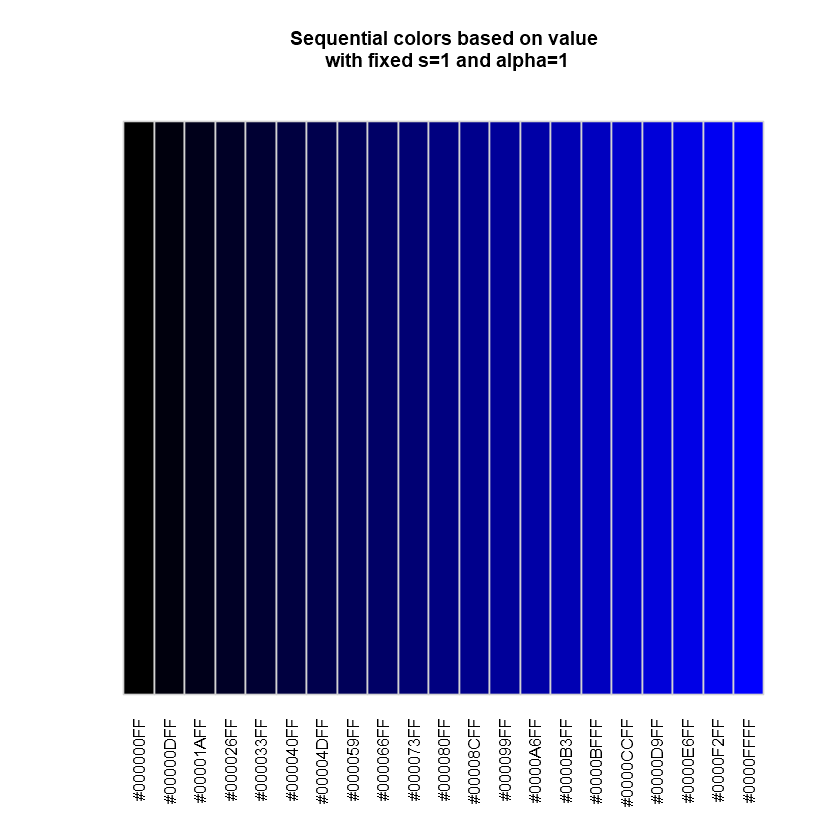

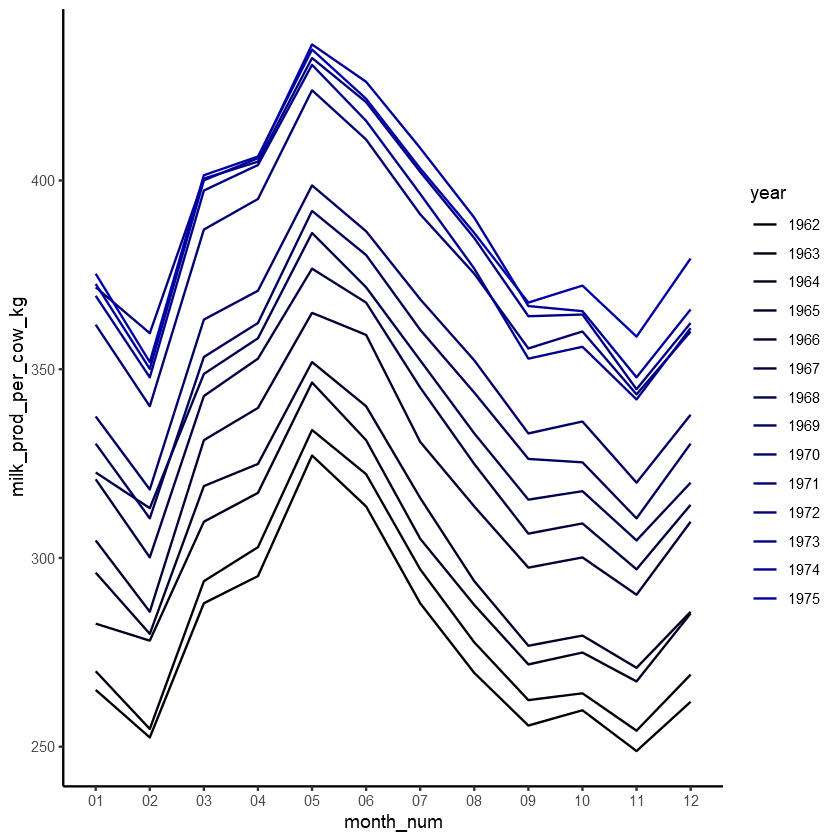

In [11]:
# Extract month and year and store in separate columns
monthly_milk$year <- format(monthly_milk$month_date, format = "%Y")
monthly_milk$month_num <- format(monthly_milk$month_date, format = "%m")

# Create a colour palette using the `colortools` package 
year_pal <- sequential(color = "blue", percentage = 5, what = "value")

# Make the plot
ggplot(monthly_milk, aes(x = month_num, y = milk_prod_per_cow_kg, group = year)) +
  geom_line(aes(colour = year)) +
  theme_classic() + 
  scale_color_manual(values = year_pal)



In [12]:
# Transform to `ts` class
monthly_milk_ts <- ts(monthly_milk$milk_prod, start = 1962, end = 1975, freq = 12)
# Specify start and end year, measurement frequency (monthly = 12)

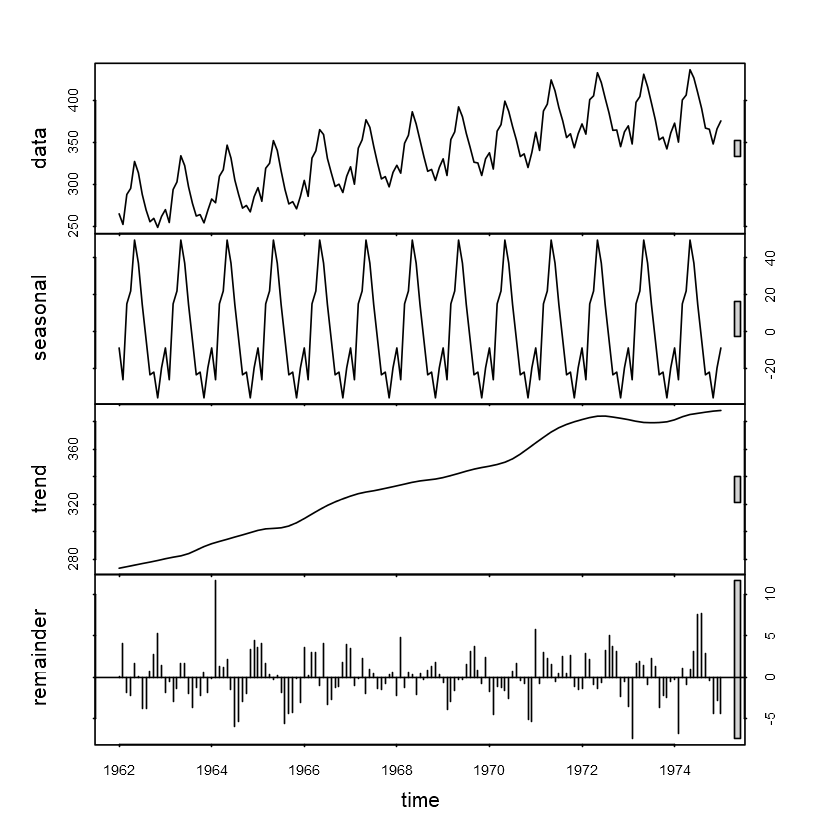

In [13]:
# Decompose using `stl()`
monthly_milk_stl <- stl(monthly_milk_ts, s.window = "period")
plot(monthly_milk_stl)

In [14]:
monthly_milk_model <- window(x = monthly_milk_ts, start = c(1962), end = c(1970))
monthly_milk_test <- window(x = monthly_milk_ts, start = c(1970))

In [15]:
# Creating model objects of each type of ets model
milk_ets_auto <- ets(monthly_milk_model)

In [17]:
milk_ets_fc <- forecast(milk_ets_auto, h = 120)

# 62 -70
#70-80 - 10 Yrs
#70-75 : Test data /my previous data known data -LAG


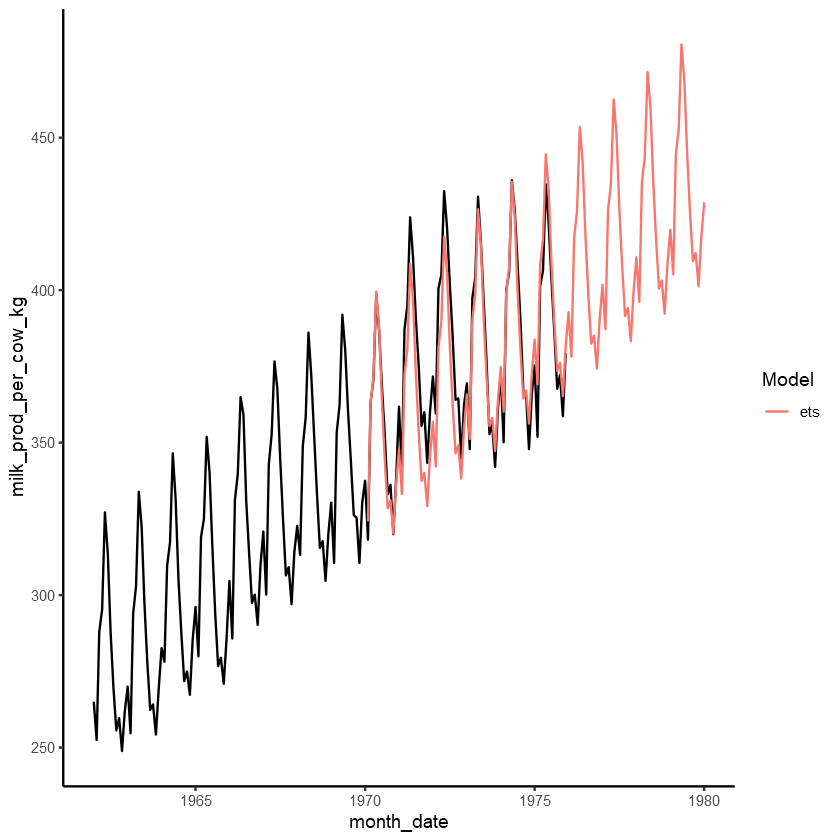

In [18]:
# Convert forecasts to data frames
milk_ets_fc_df <- cbind("Month" = rownames(as.data.frame(milk_ets_fc)), as.data.frame(milk_ets_fc))  # Creating a data frame
names(milk_ets_fc_df) <- gsub(" ", "_", names(milk_ets_fc_df))  # Removing whitespace from column names
milk_ets_fc_df$Date <- as.Date(paste("01-", milk_ets_fc_df$Month, sep = ""), format = "%d-%b %Y")  # prepending day of month to date
milk_ets_fc_df$Model <- rep("ets")  # Adding column of model type



# Combining into one data frame
forecast_all <- rbind(milk_ets_fc_df)

# Plotting with ggplot
ggplot() +
  geom_line(data = monthly_milk, aes(x = month_date, y = milk_prod_per_cow_kg)) +  # Plotting original data
  geom_line(data = forecast_all, aes(x = Date, y = Point_Forecast, colour = Model)) +  # Plotting model forecasts
  theme_classic()

In [19]:
accuracy(milk_ets_fc, monthly_milk_test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.01864308,2.726367,2.094068,0.001162836,0.675237,0.2190178,0.006994282,NA
Test set,6.49724181,10.870286,8.643747,1.687599938,2.292374,0.9040464,0.816443289,0.4875223


In [23]:
milk_ets_fc_df %>%
  filter(Month == "May 1979") %>%
  select(Month, Point_Forecast)

Month,Point_Forecast
May 1979,480.5604


In [24]:
milk_ets_fc_df

,Month,Point_Forecast,Lo_80,Hi_80,Lo_95,Hi_95,Date,Model
Feb 1970,Feb 1970,324.1319,320.3084,327.9555,318.2844,329.9795,1970-02-01,ets
Mar 1970,Mar 1970,363.2257,358.6885,367.7629,356.2867,370.1647,1970-03-01,ets
Apr 1970,Apr 1970,371.6667,366.5136,376.8198,363.7857,379.5477,1970-04-01,ets
May 1970,May 1970,399.5170,393.8139,405.2200,390.7949,408.2390,1970-05-01,ets
Jun 1970,Jun 1970,387.7353,381.5307,393.9399,378.2462,397.2244,1970-06-01,ets
Jul 1970,Jul 1970,363.7951,357.1265,370.4638,353.5963,373.9940,1970-07-01,ets
Aug 1970,Aug 1970,344.3515,337.2488,351.4541,333.4889,355.2140,1970-08-01,ets
Sep 1970,Sep 1970,328.4411,320.9294,335.9528,316.9530,339.9292,1970-09-01,ets
Oct 1970,Oct 1970,331.1034,323.2037,339.0031,319.0219,343.1850,1970-10-01,ets
Nov 1970,Nov 1970,320.2183,311.9486,328.4879,307.5709,332.8656,1970-11-01,ets


In [25]:
# JAn 1980
# 430
# 400 -455


In [26]:
# RtimeForecast.ipynb

In [27]:
# Moving Average (MA)

In [28]:
#r wallace garden method time series

rm(list=ls())

library(tidyverse)
library(forecast)

Income <- c(10,12,16,13,17,19,15,20,22,19,21,19)

Year <- c(01,  02,   03,   04,   05, 06,  07,   08,   09,   10,   11,   12)

df <- data.frame(Year,Income)
df 
str(df)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tibble  2.1.3     v purrr   0.2.5
v tidyr   0.8.1     v stringr 1.3.1
v readr   1.1.1     v forcats 0.3.0
Warning message:
"package 'tibble' was built under R version 3.5.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Year,Income
1,10
2,12
3,16
4,13
5,17
6,19
7,15
8,20
9,22
10,19


'data.frame':	12 obs. of  2 variables:
 $ Year  : num  1 2 3 4 5 6 7 8 9 10 ...
 $ Income: num  10 12 16 13 17 19 15 20 22 19 ...


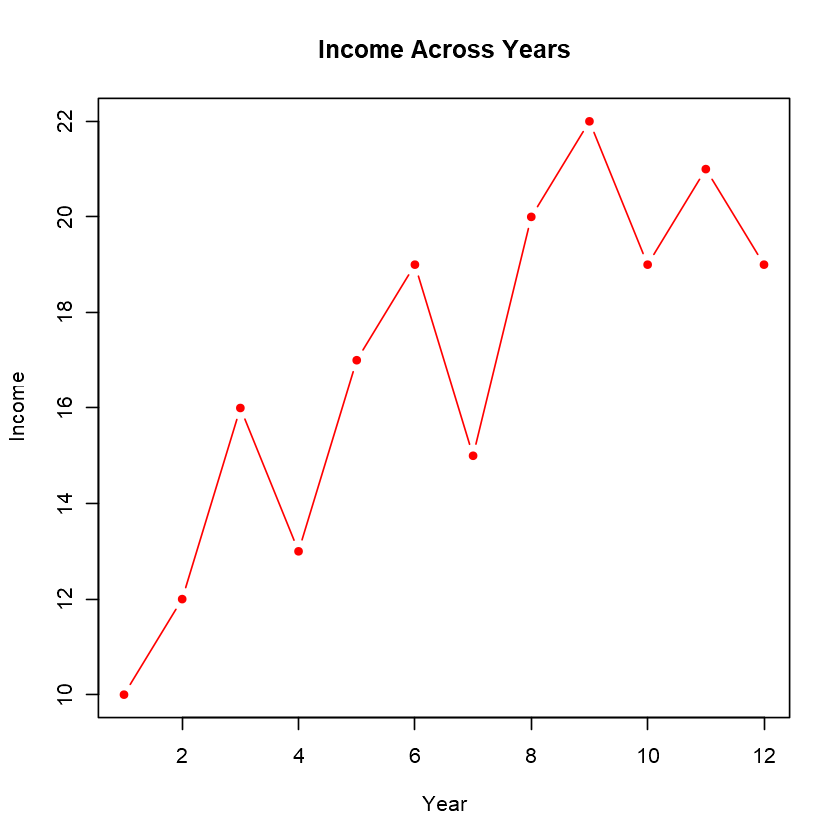

In [29]:
plot(x=df$Year,
     y=df$Income,
     xlab="Year",   # x axis lable
     ylab="Income", # y axis label
     main="Income Across Years", ## Chart title
     pch=20,  # point character
     col="red", # color of points,
     type="b"   # both points and line connecting
)

In [31]:
# https://github.com/tidyverse/dplyr/issues/1480 - Lianos - Fixing Filter_
filter_.default <- function(.data, ..., .dots) {
  fargs <- formals(stats::filter)
  dnames <- names(.dots)
  pos.args <- lapply(.dots[nchar(dnames) == 0], identity)
  named.args <- lapply(.dots[dnames %in% names(fargs)], identity)
  call.args <- lapply(c(pos.args, named.args), lazyeval::lazy_eval)
  do.call(stats::filter, c(list(.data), call.args))
}

In [32]:
# SImple Moving Average
smv <- function (s, order){
  if(is.na(order)==T){
    order <-2
  }
  sm <- filter(s,
               rep(1,order),
               sides=1
  )
  sm <- sm/order
}

## Moving Average with order 2
sma.inc.3 <-smv(df$Income,4)

In [33]:
sma.inc.3

Time Series:
Start = 1 
End = 12 
Frequency = 1 
 [1]    NA    NA    NA 12.75 14.50 16.25 16.00 17.75 19.00 19.00 20.50 20.25

In [37]:
sma.inc.5 <-smv(df$Income,6)

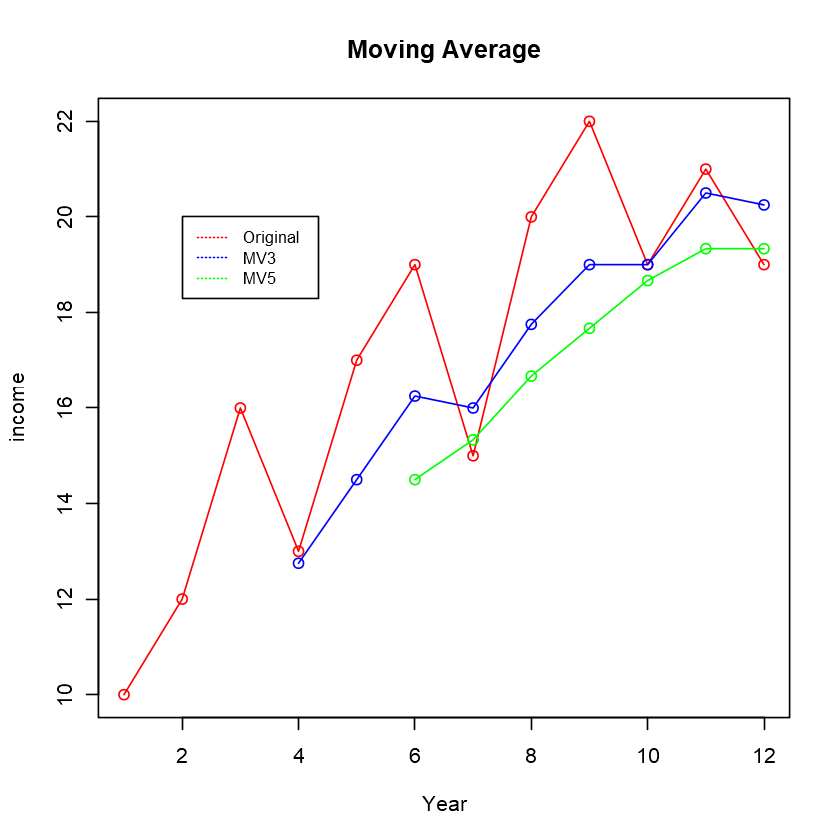

In [41]:
# Plot multiple lines each Moving Average
plot(x=df$Year,
     y=df$Income,type = "o",col = "red", xlab = "Year", ylab = "income", 
     main = "Moving Average")

lines(x=df$Year,y=sma.inc.3, type = "o", col = "blue")

lines(x=df$Year,y=sma.inc.5, type = "o", col = "green")

legend(2, 20, legend=c("Original", "MV3","MV5"),       col=c("red", "blue","green"), lty=3, cex=0.8)

In [42]:
wmv <- function (s, weights, order){
  ## default order
  if(is.na(order)==T){
    order <-2
  }
  ## check if weight vector and order are same
  if(length(weights)!=order){
    stop("Different order and weight counts") 
  }
  wm.out <- numeric()
  for (i in 1:(length(s)-order+1)){
    
    w.sum <- sum(weights)# weight sum
    w <- weights/w.sum # standardize weights
    s1 <- s[i:(i+order-1)]
    wm <- as.vector(weighted.mean(s1,w) )    
    wm.out[i] <-wm
  }
  # add fist elements as missing..
  m <- numeric()
  for(p in 1:(order-1)){
    m[p] <- NA
  }
  wm.out <- append(m,wm.out)
  wm.out
}

## Moving Average with order 2
v3 <- c(0.222,0.593,0.185,0)
# 0.222 , 0.593, 0.185 , 0

wma.inc.3 <-wmv(df$Income,v3,4)




In [43]:
wma.inc.3

[1]     NA     NA     NA 12.296 14.557 14.406 16.482 17.816 16.813 19.260
[11] 21.001 20.036

In [44]:
# WMA = <NA> <NA> <NA>  12.296 14.557 14.406 16.482 17.816 16.813 19.26 21.001 20.036 
# SMA =  NA    NA    NA 12.75  14.50 16.25 16.00 17.75 19.00 19.00 20.50 20.25


df.Year,df.Income,wma.inc.3,sma.inc.3
1,10,NA,NA
2,12,NA,NA
3,16,NA,NA
4,13,12.296,12.75
5,17,14.557,14.50
6,19,14.406,16.25
7,15,16.482,16.00
8,20,17.816,17.75
9,22,16.813,19.00
10,19,19.260,19.00


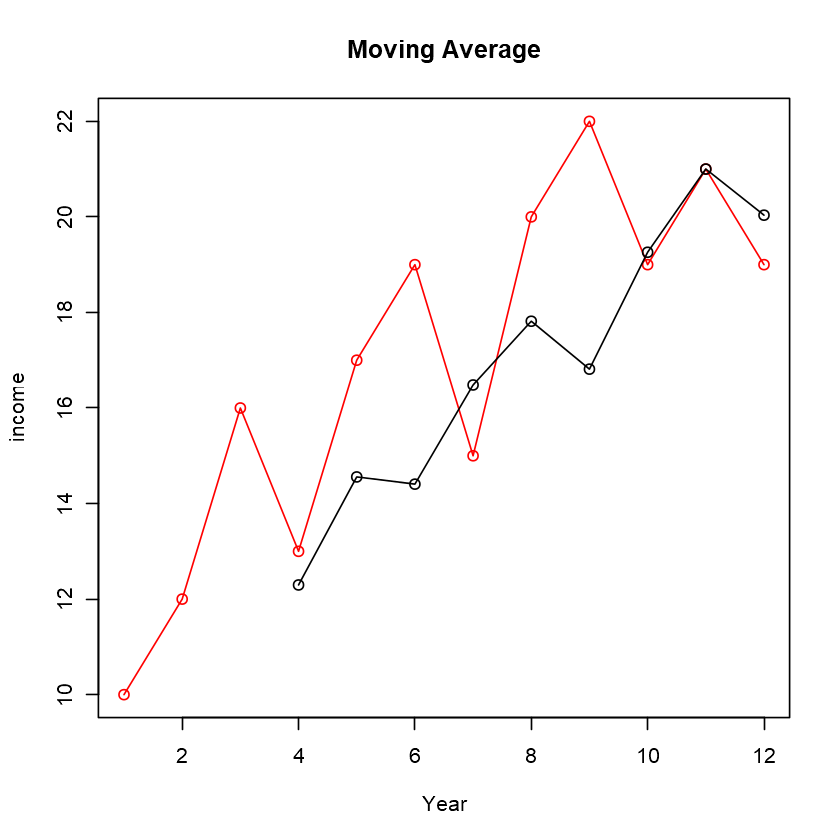

In [46]:
# Plot multiple lines each Moving Average
plot(x=df$Year,
     y=df$Income,type = "o",col = "red", xlab = "Year", ylab = "income", 
     main = "Moving Average")

lines(x=df$Year,y=wma.inc.3, type = "o", col = "black")

legend(16, 20, legend=c("Original", "MMV2"),
       col=c("red", "black"), lty=5, cex=0.8)


df3 <- data.frame(df$Year,df$Income, wma.inc.3, sma.inc.3)
df3

In [47]:
library("dplyr")

df3 <- df3 %>%
  mutate(Error = df$Income - wma.inc.3,
         abserror = abs(df$Income - wma.inc.3) ,
         sqderror = abs(df$Income - wma.inc.3)^2,
         abdError = abs(100 - (wma.inc.3 *100)/ df$Income )
         )

#df3
BIAS = mean(df3$Error,na.rm=TRUE)
MAD = mean(df3$abserror,na.rm=TRUE)
MSE = mean(df3$sqderror ,na.rm=TRUE)
MAPE = mean(df3$abdError ,na.rm=TRUE)

final = data.frame(BIAS, MAD,MSE,MAPE)
final

BIAS,MAD,MSE,MAPE
1.370333,1.987889,6.953416,10.57422


In [48]:
# MAPE = 10.57 , If we got less than this, by altering Weights, then that is the Good model

In [49]:
# 
# Time Series
data(AirPassengers)
summary(AirPassengers)
frequency(AirPassengers)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  104.0   180.0   265.5   280.3   360.5   622.0 

[1] 12

[1] "ts"

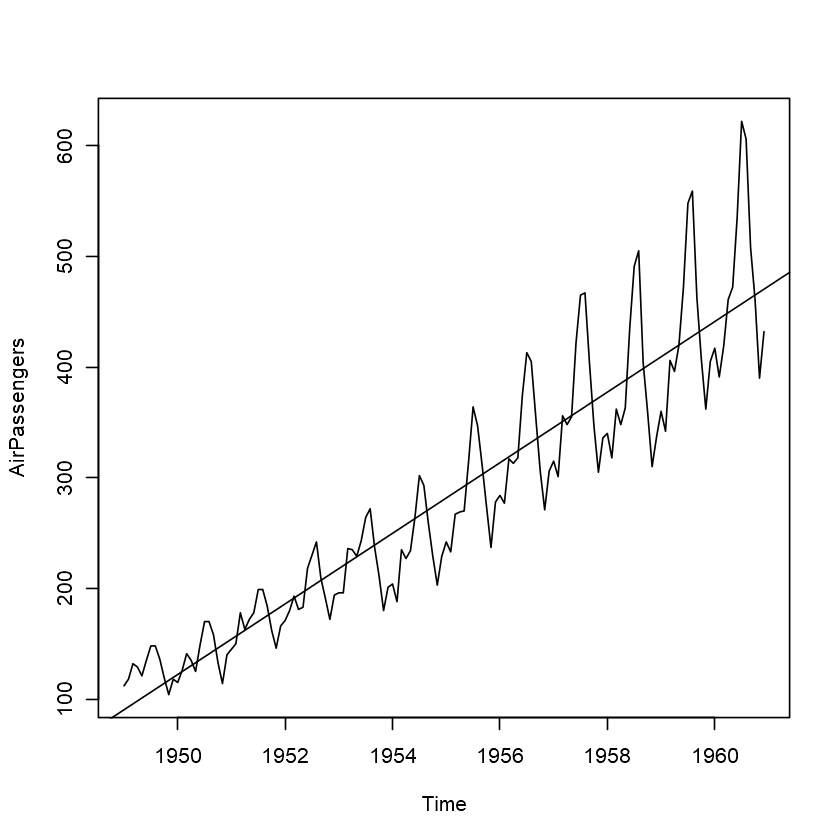

In [50]:
class(AirPassengers)

plot(AirPassengers)
abline(reg=lm(AirPassengers~time(AirPassengers)))

In [52]:
library(tseries)
adf.test(diff(log(AirPassengers)),
         alternative="stationary", k=3)

Warning message in adf.test(diff(log(AirPassengers)), alternative = "stationary", :
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  diff(log(AirPassengers))
Dickey-Fuller = -8.9177, Lag order = 3, p-value = 0.01
alternative hypothesis: stationary


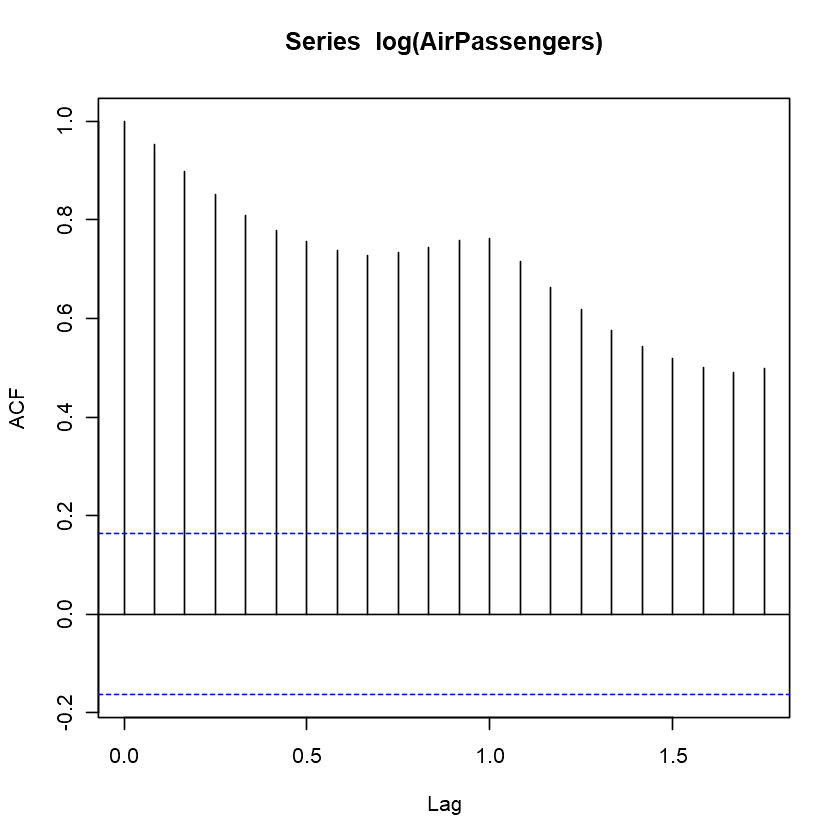

In [54]:
#find the right parameters to be used in the ARIMA model
acf(log(AirPassengers))


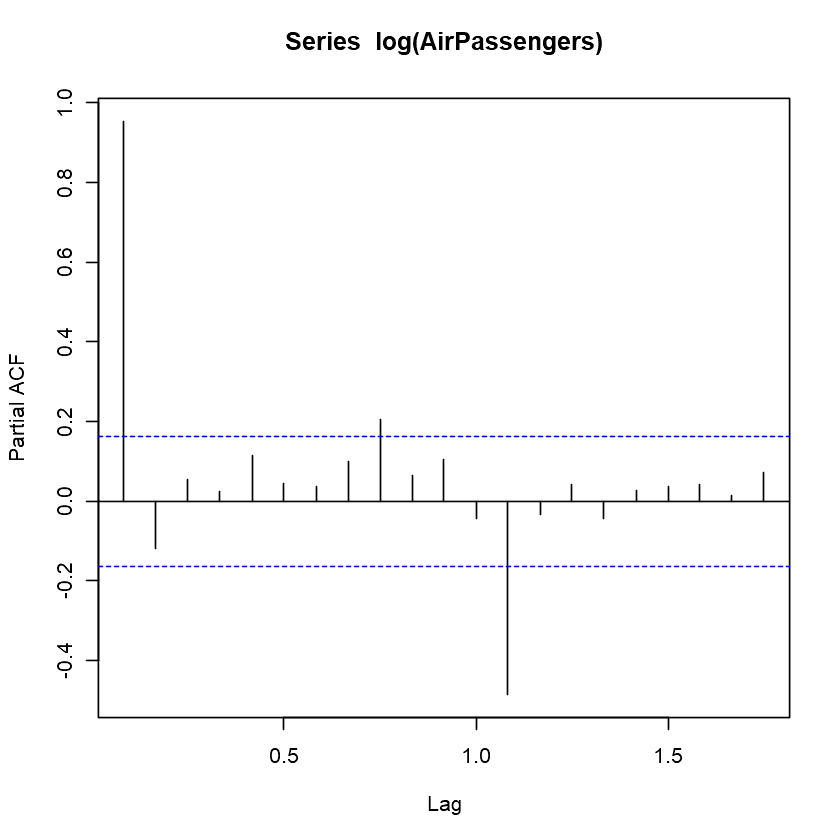

In [55]:
pacf(log(AirPassengers))


[1] 1

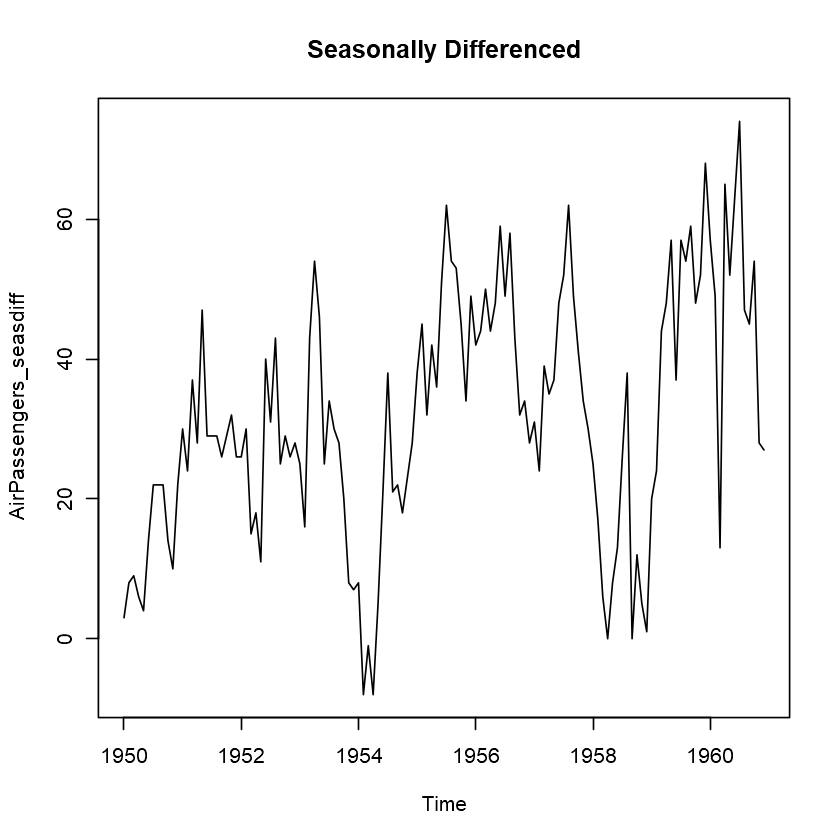

In [56]:
library("forecast")

nsdiffs(AirPassengers)  # number for seasonal differencing needed
#> 1


AirPassengers_seasdiff <- diff(AirPassengers, lag=frequency(AirPassengers),
                               differences=1)  # seasonal differencing
plot(AirPassengers_seasdiff, type="l", main="Seasonally Differenced")

In [57]:

# still not stationary!

# Make it stationary

[1] 1

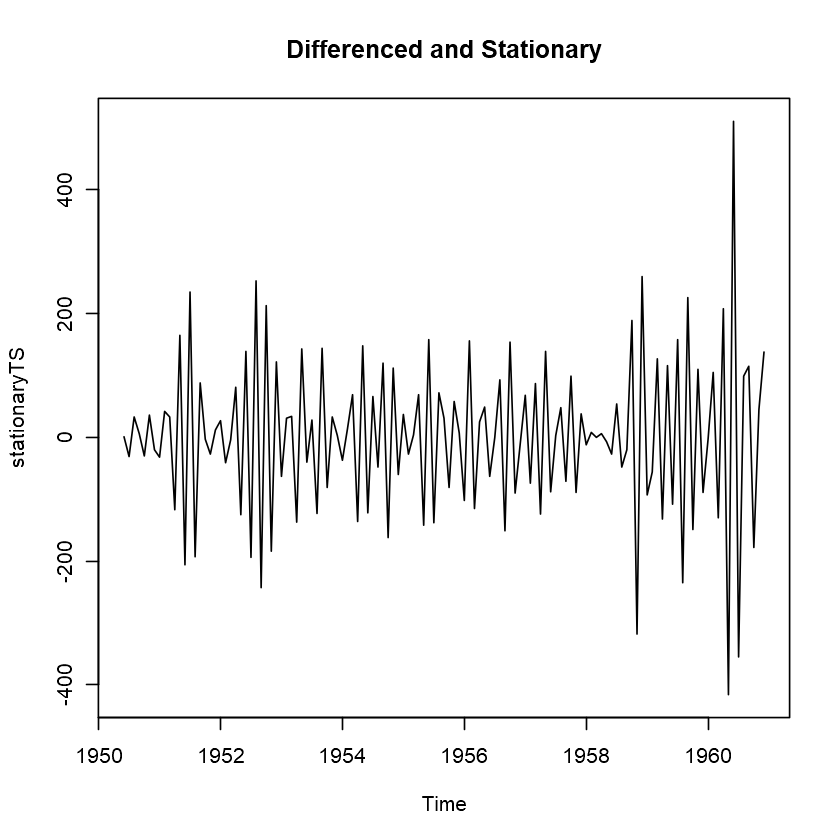

In [60]:
ndiffs(AirPassengers_seasdiff)  # number of differences need to make it stationary
#> 1 
stationaryTS <- diff(AirPassengers_seasdiff, differences= 5)
plot(stationaryTS, type="l", main="Differenced and Stationary")  